In [3]:
#importing required Libraries
import numpy as np
import os
from PIL import Image
import time
import copy
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import torch 
import torchvision as tv
from torchsummary import summary
from torchmetrics.classification import Accuracy
import lightning as Light
# import ignite
%matplotlib inline

c:\Users\varte\Documents\University\Year 4 Sem. 2\4442\LlamaOrDuck\venv\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [4]:
# Chech if CUDA is working, set appropriate device
device = None
device_str = None
if torch.cuda.is_available():
    print("CUDA working \U0001F911")
    device_str = 'cuda'
    if('4060' in torch.cuda.get_device_name(0)):
        emoji = '\U0001F60D' 
    elif('GTX' in torch.cuda.get_device_name(0)):
           emoji = '\U0001F642'
    elif('TPU' in torch.cuda.get_device_name(0)):
           emoji = '\U0001F47D'
    else: emoji = '\U0001F601'
    print(f"This user has a {torch.cuda.get_device_name(0)} {emoji}") # flex your GPUs here
else:
    print("CUDA not working - running on CPU \U0001F480")
    device_str = 'cpu'
device = torch.device(device_str)


CUDA working 🤑
This user has a NVIDIA GeForce GTX 1650 Ti 🙂


In [5]:
train_dataset_path = 'dataset/data/train'
test_dataset_path = 'dataset/data/test'
validation_dataset_path = 'dataset/data/val'

# colab = False
# if colab:
#   from google.colab import drive
#   colab_path = '/content/drive/MyDrive/Colab Notebooks/'
#   drive.mount('/content/drive')

#   train_dataset_path = colab_path+train_dataset_path
#   test_dataset_path = colab_path+test_dataset_path
#   validation_dataset_path = colab_path +validation_dataset_path

In [6]:
IMG_SIZE = (64,64)
training_transforms = tv.transforms.Compose([tv.transforms.Resize(IMG_SIZE), tv.transforms.ToTensor()])
train_dataset = tv.datasets.ImageFolder(root = train_dataset_path, transform = training_transforms)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=32, shuffle=False)

def get_mean_and_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch

    mean /= total_images_count
    std /= total_images_count

    return mean, std

mean, std = get_mean_and_std(train_loader)

In [7]:
mean = mean[0]
std = std[0]

# We can use 3 input channels (r,g,b) or covert it to grayscale for 1 channel

# Some more filters we can apply for preprocessing
# .transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=<InterpolationMode.BILINEAR: 'bilinear'>, fill=0)
# transforms.GaussianBlur(kernel_size, sigma=(0.1, 2.0))

train_transforms = tv.transforms.Compose([
    tv.transforms.Resize(IMG_SIZE),       # need to use the same resize size or else std changes for each size
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(15),
    tv.transforms.Grayscale(num_output_channels=1), 
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean, std)
])
rgb_train_transforms = tv.transforms.Compose([
    tv.transforms.Resize(IMG_SIZE),       # need to use the same resize size or else std changes for each size
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(15),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean, std)
])

test_transforms = tv.transforms.Compose([
    tv.transforms.Resize(IMG_SIZE),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(15),
    tv.transforms.Grayscale(num_output_channels=1), 
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean, std)
])

rgb_test_transforms = tv.transforms.Compose([
    tv.transforms.Resize(IMG_SIZE),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(15),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean, std)
])

In [29]:
train_dataset = tv.datasets.ImageFolder(root = train_dataset_path, transform = train_transforms)
test_dataset = tv.datasets.ImageFolder(root = test_dataset_path, transform = test_transforms)
validation_dataset = tv.datasets.ImageFolder(root = validation_dataset_path, transform = test_transforms)
rgb_train_dataset = tv.datasets.ImageFolder(root = train_dataset_path, transform = rgb_train_transforms)
rgb_test_dataset = tv.datasets.ImageFolder(root = test_dataset_path, transform = rgb_test_transforms)
rgb_validation_dataset = tv.datasets.ImageFolder(root = validation_dataset_path, transform = rgb_test_transforms)

labels = np.array([sample[1] for sample in train_dataset])
class_counts = np.bincount(labels)
class_weights = 1. / class_counts
sample_weights = class_weights[labels]
train_sampler = torch.utils.data.WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

labels = np.array([sample[1] for sample in validation_dataset])
class_counts = np.bincount(labels)
class_weights = 1. / class_counts
sample_weights = class_weights[labels]
validation_sampler = torch.utils.data.WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

labels = np.array([sample[1] for sample in test_dataset])
class_counts = np.bincount(labels)
class_weights = 1. / class_counts
sample_weights = class_weights[labels]
test_sampler = torch.utils.data.WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

dataset_sizes = {'train': len(train_dataset), 'val': len(validation_dataset), 'test': len(test_dataset)}
print(train_dataset.class_to_idx)

{'animal duck': 0, 'llama': 1}


In [9]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = tv.utils.make_grid(images, nrow = 3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5097134..2.5768993].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5097134..2.5768993].


labels:  tensor([1, 0, 1, 0, 1, 0])
labels:  tensor([0, 1, 1, 1, 1, 1])


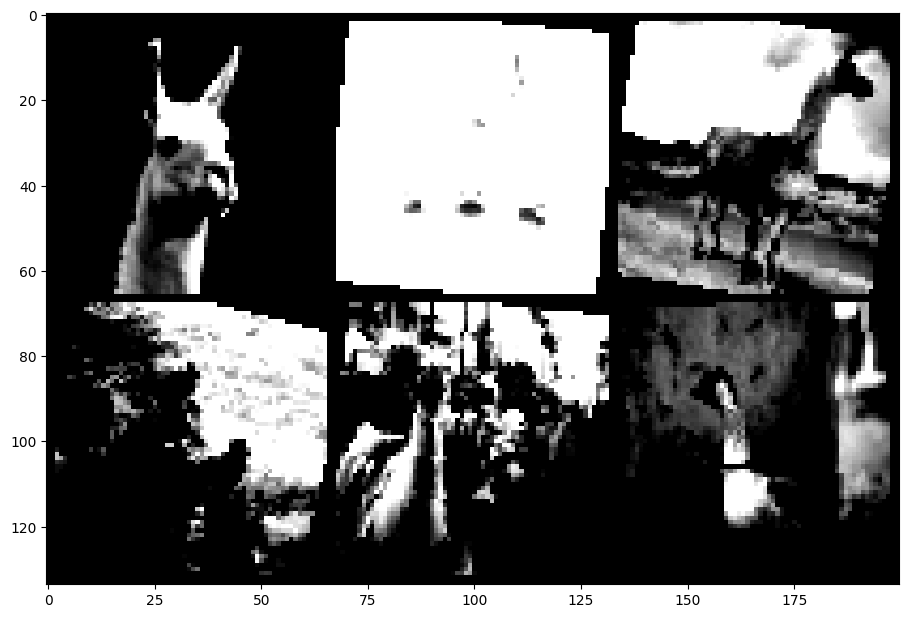

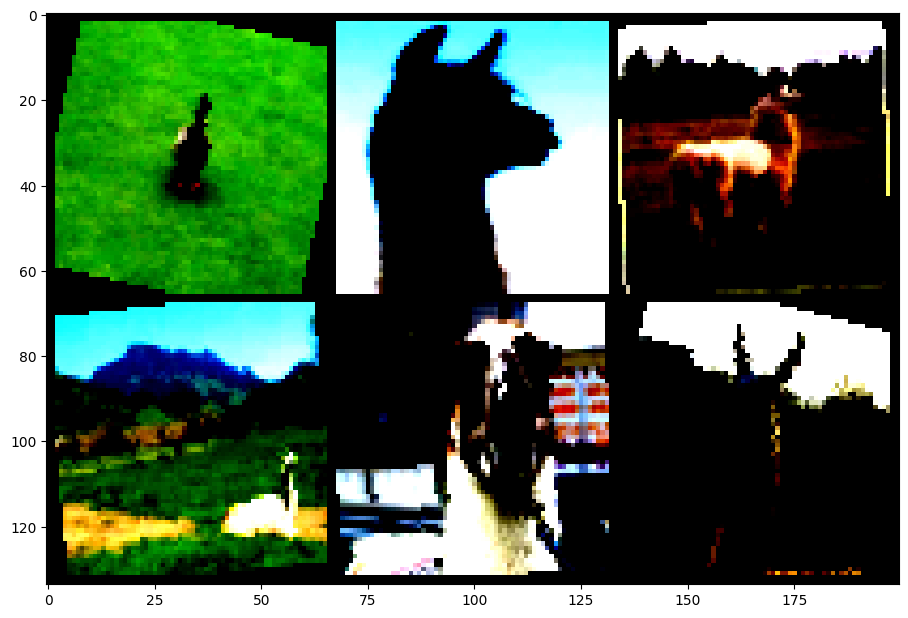

In [10]:
show_transformed_images(train_dataset)
show_transformed_images(rgb_train_dataset)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, sampler=test_sampler)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 64, sampler=validation_sampler)
rgb_train_loader = torch.utils.data.DataLoader(rgb_train_dataset, batch_size = 64, sampler=train_sampler)
rgb_test_loader = torch.utils.data.DataLoader(rgb_test_dataset, batch_size = 64, sampler=test_sampler)
rgb_validation_loader = torch.utils.data.DataLoader(rgb_validation_dataset, batch_size = 64, sampler=validation_sampler)

print("Dataset sizes:")
class_counts = [0,0]
for _,y in train_loader:
    class_counts += np.bincount(y)
print(f"Train: duck: {class_counts[0]} - llama: {class_counts[1]}")

class_counts = [0,0]
for _,y in validation_loader:
    class_counts += np.bincount(y)
print(f"Validation: duck: {class_counts[0]} - llama: {class_counts[1]}")
class_counts = [0,0]
for _,y in test_loader:
    class_counts += np.bincount(y)
print(f"Test: duck: {class_counts[0]} - llama: {class_counts[1]}")

Dataset sizes
Train: duck: 724 - llama: 723
Validation: duck: 130 - llama: 106
Test: duck: 358 - llama: 373


In [13]:
def evaluate(model, dataloader, criterion, optimizer):
    criterion=criterion.to(device)
    model.eval()
    preds = []
    y_true = []
    losses=[]
    accuracies = []
    running_corrects = 0
    running_loss = 0.0
    for X,y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()  
        with torch.set_grad_enabled(True):
            yhat = model(X) 
            loss = criterion(yhat, y) 
            _, preds = torch.max(yhat, 1)
        loss = criterion(yhat, y)
        running_loss += loss.item() * X.size(0)
        running_corrects += torch.sum(preds == y.data)
    del model, dataloader,criterion
    return running_corrects, running_loss


def fit(model, model_name, criterion, optimizer, epochs=1, rgb=False, verbose=1):
    # define the loss function
    # determine the gradient descent algorithm to be used for updating weights
    training_losses = []
    val_losses = []
    training_accs = []
    val_accs = []
    best_epoch = 0
    
    curr_model = model.to(device)
    criterion = criterion.to(device)
    retry = 0
    correct_train_loader = rgb_train_loader if rgb else train_loader
    correct_validation_loader = rgb_validation_loader if rgb else validation_loader
    correct_test_loader = rgb_test_loader if rgb else test_loader
    
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(epochs)): 
        print(f'Epoch {epoch+1}/{epochs}')
        print('-=+=' * 10)
        running_loss=0.
        running_corrects = 0
        try:
            model.train()
            for X,y in correct_train_loader: 
                X, y = X.to(device), y.to(device)
                # print("predicting")
                optimizer.zero_grad()  
                with torch.set_grad_enabled(True):
                    yhat = curr_model(X) 
                    loss = criterion(yhat, y) 
                    _, preds = torch.max(yhat, 1)
                # print("done predicting")
                # backward prop for loss function and calculate gradients of all the layers in the net
                loss.backward()    
                # update the weights   
                optimizer.step() 

                running_loss += loss.item() * X.size(0)
                running_corrects += torch.sum(preds == y.data)
                
            # print("evaluating")    
            val_corrects, val_loss_sum = evaluate(model, correct_validation_loader, criterion, optimizer)
            #  TODO if val loss increasing or not improving, don't do more epochs?
            # print("done evaluating")   
            epoch_loss = running_loss / dataset_sizes["train"]
            epoch_acc = running_corrects.double() / dataset_sizes["train"]

            val_loss = val_loss_sum / dataset_sizes["val"]
            val_acc = val_corrects.double() / dataset_sizes["val"]
            training_losses.append(epoch_loss)
            training_accs.append(epoch_acc.to(torch.device("cpu")))
            val_losses.append(val_loss)
            val_accs.append(val_acc.to(torch.device("cpu")))
            if verbose>2: print(f"Epoch: {epoch} training loss is: {epoch_loss}, acc:{epoch_acc}")
            if verbose>1: print(f"Validation Loss: {val_loss}, Accuracy: {val_acc}")

            # keep copy of best model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch=epoch


        except torch.cuda.OutOfMemoryError as e:
            print(e)
            if retry>2:
                break
            else:
                torch.cuda.empty_cache()
                retry+=1

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    # save best model so it doesnt need to be retrained
    model.load_state_dict(best_model_wts)
    # if(colab):
    #     torch.save(curr_model.state_dict(), f'{model_name}.pt') 
    # else:
    with open(model_name+'.pt', 'wb') as f: 
        torch.save(curr_model.state_dict(), f) 

    test_corrects, test_loss_sum = evaluate(model, correct_test_loader, criterion, optimizer)
    test_loss = test_loss_sum / dataset_sizes["test"]
    test_acc = (test_corrects.double() / dataset_sizes["test"]).to(torch.device("cpu"))
    if verbose: print(f"test Loss: {test_loss}, Accuracy: {test_acc}")
    del model, criterion
    torch.cuda.empty_cache()
    return training_losses, training_accs, val_losses, val_accs, test_loss, test_acc, best_epoch


In [14]:
densenet = tv.models.densenet121(weights=tv.models.DenseNet121_Weights.DEFAULT) #DenseNet121_Weights.DEFAULT - DenseNet121_Weights.IMAGENET1K_V1
num_classes = len(train_dataset.classes)  # In case we decide to add more classes
num_ftrs = densenet.classifier.in_features
densenet.classifier = torch.nn.Linear(num_ftrs, num_classes)


In [ ]:
class Gray_CNN1(torch.nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=(3,3)), #input of 1 channel, change first number to 3 for rgb 
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2), # drop 20% of values
            torch.nn.MaxPool2d(2,2), # get max value from (2,2) square -> halve the width and height of feature matrix
            torch.nn.Conv2d(32, 32, kernel_size=(3,3), stride=1), 
            torch.nn.ReLU(),
            torch.nn.Flatten(), 
            torch.nn.Linear(32 * 125 * 125, 128), 
            # 248 because we start from 256 and each conv2d layer removes 2 columns and rows b/c no padding and 3x3 kernel
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, 2),
        )

    def forward(self, x): 
        return self.model(x)
    
class RGB_CNN1(torch.nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=(3,3)),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2), # drop 20% of values
            torch.nn.MaxPool2d(2,2), # get max value from (2,2) square -> halve the width and height of feature matrix
            torch.nn.Conv2d(32, 32, kernel_size=(3,3), stride=1), 
            torch.nn.ReLU(),
            torch.nn.Flatten(), 
            torch.nn.Linear(32 * 125 * 125, 128), 
            # 248 because we start from 256 and each conv2d layer removes 2 columns and rows b/c no padding and 3x3 kernel
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, 2),
        )

    def forward(self, x): 
        return self.model(x)
    

class Gray_CNN1_64(torch.nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=(3,3)), #input of 1 channel, change first number to 3 for rgb 
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2), # drop 20% of values
            torch.nn.MaxPool2d(2,2), # get max value from (2,2) square -> halve the width and height of feature matrix
            torch.nn.Conv2d(32, 32, kernel_size=(3,3), stride=1), 
            torch.nn.ReLU(),
            torch.nn.Flatten(), 
            torch.nn.Linear(32 * 29 * 29, 128), 
            # 248 because we start from 256 and each conv2d layer removes 2 columns and rows b/c no padding and 3x3 kernel
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, 2),
        )

    def forward(self, x): 
        return self.model(x)
    
summary(RGB_CNN1().to(device), input_size=(3, IMG_SIZE[0],IMG_SIZE[1]), device=device_str)
torch.cuda.empty_cache()

In [73]:
class AlexNet(torch.nn.Module): 
    def __init__(self):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(256 * 6 * 6, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, 2),
            # torch.nn.Linear(4096, 512), # AlexNet2 differs here
            # torch.nn.Linear(512, 64), # and here
            # torch.nn.Linear(64, 2), # and here
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
summary(AlexNet().to(device), input_size=(3, IMG_SIZE[0],IMG_SIZE[1]), device=device_str)
torch.cuda.empty_cache()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 15, 15]          23,296
              ReLU-2           [-1, 64, 15, 15]               0
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4            [-1, 192, 7, 7]         307,392
              ReLU-5            [-1, 192, 7, 7]               0
         MaxPool2d-6            [-1, 192, 3, 3]               0
            Conv2d-7            [-1, 384, 3, 3]         663,936
              ReLU-8            [-1, 384, 3, 3]               0
            Conv2d-9            [-1, 256, 3, 3]         884,992
             ReLU-10            [-1, 256, 3, 3]               0
           Conv2d-11            [-1, 256, 3, 3]         590,080
             ReLU-12            [-1, 256, 3, 3]               0
        MaxPool2d-13            [-1, 256, 1, 1]               0
AdaptiveAvgPool2d-14            [-1, 25

In [74]:
epochs = 25
rgb=True
model_name= "AlexNet"
curr_model = AlexNet()
criterion = torch.nn.CrossEntropyLoss() # TODO implement BCE?
criterion_name = "CrossEntropyLoss"
optimizer = torch.optim.Adam(curr_model.parameters(), lr = 1e-3)
# TODO add scheduler?
 
# open a previously trained model
try:
    with open(model_name+'.pt', 'rb') as f:
        curr_model.load_state_dict(torch.load(f))  
except FileNotFoundError:
    print("Model does not exist yet")
    
training_losses, training_accs, val_losses, val_accs, test_loss, test_acc, best_epoch = fit(model=curr_model, model_name=model_name, criterion=criterion, optimizer=optimizer, epochs = epochs, rgb=rgb, verbose = 1)

Model does not exist yet


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


  4%|▍         | 1/25 [00:24<09:53, 24.72s/it]

Epoch 2/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


  8%|▊         | 2/25 [00:49<09:27, 24.69s/it]

Epoch 3/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 12%|█▏        | 3/25 [01:13<08:55, 24.33s/it]

Epoch 4/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 16%|█▌        | 4/25 [01:37<08:33, 24.45s/it]

Epoch 5/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 20%|██        | 5/25 [02:02<08:07, 24.37s/it]

Epoch 6/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 24%|██▍       | 6/25 [02:26<07:42, 24.35s/it]

Epoch 7/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 28%|██▊       | 7/25 [02:50<07:16, 24.26s/it]

Epoch 8/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 32%|███▏      | 8/25 [03:14<06:48, 24.04s/it]

Epoch 9/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 36%|███▌      | 9/25 [03:38<06:24, 24.01s/it]

Epoch 10/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 40%|████      | 10/25 [04:02<06:00, 24.01s/it]

Epoch 11/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 44%|████▍     | 11/25 [04:26<05:36, 24.00s/it]

Epoch 12/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 48%|████▊     | 12/25 [04:50<05:12, 24.01s/it]

Epoch 13/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 52%|█████▏    | 13/25 [05:13<04:47, 23.93s/it]

Epoch 14/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 56%|█████▌    | 14/25 [05:37<04:22, 23.88s/it]

Epoch 15/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 60%|██████    | 15/25 [06:01<03:59, 23.92s/it]

Epoch 16/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 64%|██████▍   | 16/25 [06:25<03:34, 23.85s/it]

Epoch 17/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 68%|██████▊   | 17/25 [06:49<03:10, 23.86s/it]

Epoch 18/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 72%|███████▏  | 18/25 [07:12<02:46, 23.85s/it]

Epoch 19/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 76%|███████▌  | 19/25 [07:37<02:23, 23.90s/it]

Epoch 20/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 80%|████████  | 20/25 [08:01<01:59, 23.97s/it]

Epoch 21/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 84%|████████▍ | 21/25 [08:25<01:35, 23.98s/it]

Epoch 22/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 88%|████████▊ | 22/25 [08:48<01:11, 23.89s/it]

Epoch 23/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 92%|█████████▏| 23/25 [09:13<00:48, 24.04s/it]

Epoch 24/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


 96%|█████████▌| 24/25 [09:36<00:23, 23.92s/it]

Epoch 25/25
-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=-=+=


100%|██████████| 25/25 [10:00<00:00, 24.01s/it]


Training complete in 10m 0s
Best val Acc: 0.8563
test Loss: 0.5158138462481192, Accuracy: 0.79890560875513


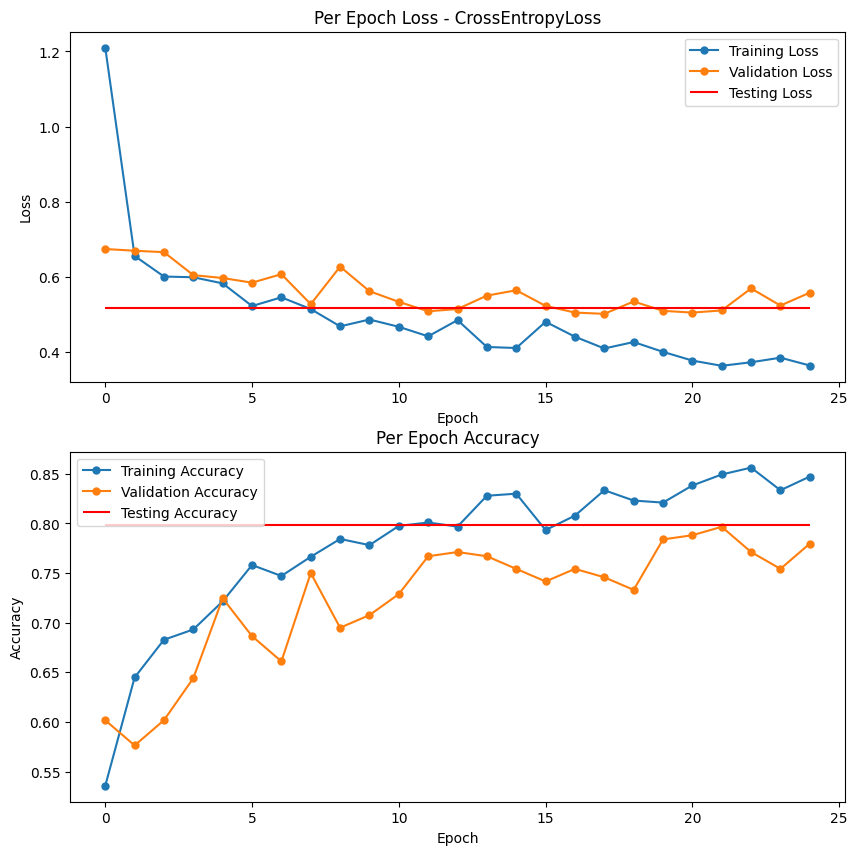

In [75]:
num_epochs = len(training_losses)
plt.figure(figsize=(10,10))
plt.subplot(2,1, 1)
plt.plot(range(0,num_epochs),training_losses, marker='o', markersize=5, label="Training Loss")
plt.plot(range(0,num_epochs), val_losses, marker='o', markersize=5, label="Validation Loss")
plt.hlines(test_loss, 0, num_epochs-1, colors='r', label="Testing Loss")
# plt.vlines(best_epoch, np.min(training_losses), np.max(training_losses), colors='g')
# plt.ylim(min(min(training_losses), min(val_losses), test_loss)-0.0125, min(max(training_losses), max(val_losses), test_loss, 2)+0.0125)
# plt.ylim(0.5,0.8)
plt.title(f"Per Epoch Loss - {criterion_name}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')

plt.subplot(2,1, 2)
plt.plot(range(0,num_epochs), training_accs, marker='o', markersize=5, label="Training Accuracy")#np.linspace(0, num_epochs, num_epochs))
plt.plot(range(0,num_epochs), val_accs, marker='o', markersize=5, label="Validation Accuracy")
plt.hlines(test_acc, 0, num_epochs-1, colors='r', label="Testing Accuracy")
# plt.vlines(best_epoch, np.min(training_accs), np.max(training_accs), colors='g')
plt.title(f"Per Epoch Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')


# plt.subplot(2,2, 3)
# plt.plot(range(0,num_epochs), val_losses, marker='o', markersize=5)
# plt.hlines(test_loss, 0, num_epochs-1, colors='r')
# # plt.vlines(best_epoch, np.min(val_losses), np.max(val_losses), colors='g')
# plt.title(f"Epoch Validation Loss - {criterion_name}")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")

# plt.subplot(2,2, 4)
# plt.plot(range(0,num_epochs), val_accs, marker='o', markersize=5)
# plt.hlines(test_acc, 0, num_epochs-1, colors='r')
# # plt.vlines(best_epoch, np.min(val_accs), np.max(val_accs), colors='g')
# plt.title(f"Epoch Validation Accuracy")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.savefig(?)
plt.show()